In [1]:
import pypsa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Notebook Demonstrating PyPSA's Capabilities relevant to our project

In [2]:
def fuel_line_efficiency(d):
    return 0.97*d

def elec_line_efficiency(d):
    return 0.9*d

def distance(loc1, loc2):
    return 1

plant_scale = 0.5


In [3]:


def add_distribution_node(j,
                          network,
                          electrolysis=False,
                          p_nom_combustion=10,
                          p_nom_electrolysis=10,
                          electrolysis_efficiency = 0.4,
                          combustion_efficiency = 0.4,
                          loc = (0,0)):
    """
    Add a local distribution node to a PyPSA network with electric and fuel buses,
    and optionally include electrolysis for fuel production.

    This function creates a pair of buses representing an electricity and a methane
    (CH₄) fuel node, connected via a combustion link (CH₄ → electricity).
    If `electrolysis=True`, it also adds an electrolysis link that converts
    electricity back into methane (electricity → CH₄), representing reversible
    energy conversion at the distribution node.

    Parameters
    ----------
    j : int or str
        Index or label for the distribution node (used in naming).
    network : pypsa.Network
        The PyPSA network object to which the buses and links will be added.
    electrolysis : bool, optional
        If True, add an electrolysis link (electricity → CH₄). Default is False.
    p_nom_combustion : float, optional
        Nominal power capacity [MW] of the combustion link. Default is 10.
    p_nom_electrolysis : float, optional
        Nominal power capacity [MW] of the electrolysis link (if added). Default is 10.
    electrolysis_efficiency : float, optional
        Conversion efficiency (0–1) from electricity to CH₄ for electrolysis. Default is 0.4.
    combustion_efficiency : float, optional
        Conversion efficiency (0–1) from CH₄ to electricity for combustion. Default is 0.4.
    loc1 : tuple of float, optional
        (x, y) coordinates of the node for plotting purposes. Default is (0, 0).

    Returns
    -------
    None
        The function modifies the provided PyPSA network in place by adding new buses and links.

    Notes
    -----
    - The created components include:
        * Bus: "DNode{j}_Elec" (Electricity)
        * Bus: "DNode{j}_Fuel" (CH₄)
        * Link: "combustion_distrib{j}" (CH₄ → Electricity)
        * Link: "electrolysis_Distrib{j}" (Electricity → CH₄, if enabled)
    - The `plant` attribute is set to `j` for all added components.
    - Link directions follow the convention of PyPSA’s `bus0` → `bus1`.
    """
    
    # Electric Bus
    elec_node_name = "DNode"+str(j)+"_Elec"
    network.add("Bus", elec_node_name, carrier="Electricity", plant = j,  x=loc[0] - plant_scale, y = loc[1])

    # Fuel Bus
    fuel_node_name ="DNode"+str(j)+"_Fuel"
    network.add("Bus", fuel_node_name, carrier="CH4", plant = j,  x=loc[0] + plant_scale, y = loc[1])

    # Combustion Link
    link_name = "combustion_distrib"+str(j)
    network.add("Link",
                link_name,
                p_nom=p_nom_combustion,
                efficiency=combustion_efficiency,
                bus0 = fuel_node_name,
                bus1 = elec_node_name,
                carrier="CH4",
                conversion = True,
                )

    # Electrolysis Link
    if electrolysis:
        electrolysis_name = "electrolysis_Distrib"+str(j)
        network.add("Link",
                    electrolysis_name,
                    p_nom=p_nom_electrolysis,
                    efficiency=electrolysis_efficiency,
                    bus1 = fuel_node_name,
                    bus0 = elec_node_name,
                    carrier="Electricity",
                    conversion = True,
                    )

def add_load_node(j,
                  network,
                  distrib_node,
                  load=1,
                  p_nom_combustion=1000,
                  combustion_efficiency=0.2,
                  loc = (0,0),
                  ):
    
    # Electric Bus
    elec_node_name = "LNode"+str(j)+"_Elec"
    network.add("Bus", elec_node_name, carrier="Electricity", x=loc[0] - plant_scale, y = loc[1])

    # Fuel Bus
    fuel_node_name ="LNode"+str(j)+"_Fuel"
    network.add("Bus", fuel_node_name, carrier="CH4", x=loc[0] + plant_scale, y = loc[1])
    

    # Electric Load
    load_name = "load" + str(j)
    network.add("Load", load_name, p_set = load, carrier = "Electricity", bus = elec_node_name)


    # Connections to the distrib node
    elec_link_name = "elec_load_link" + str(j)
    network.add("Link",
                elec_link_name,
                p_nom = 100,
                efficiency = 0.9,
                bus0 = "DNode"+str(distrib_node)+"_Elec",
                bus1 = elec_node_name,
                carrier="Electricity",
                conversion = False,
                )
    fuel_link_name = "fuel_load_link" + str(j)
    network.add("Link",
                fuel_link_name,
                p_nom = 100,
                efficiency = 0.9,
                bus0 = "DNode"+str(distrib_node)+"_Fuel",
                bus1 = fuel_node_name,
                carrier="CH4",
                conversion = False,
                )
    
    
    # In home CH4 -> Elec generator
    combustionlink_name = "combustion_household"+str(j)
    network.add("Link",
                combustionlink_name,
                p_nom=p_nom_combustion,
                efficiency=combustion_efficiency,
                bus0 = fuel_node_name,
                bus1 = elec_node_name,
                carrier="CH4",
                conversion = True)
    
def add_fuel_generation_node(j,
                             network,
                             distrib_nodes,
                             pmax, 
                             loc = (0,0),
                             marg_cost = 10):
    # Creating bus representing a fracking site
    bus_node_name = "generation_bus_fuel"+str(j)
    network.add("Bus", bus_node_name, carrier="CH4", x = loc[0], y = loc[1])

    # Generator
    generator_name = "generator_fuel"+str(j)
    network.add("Generator", generator_name, carrier="CH4", p_nom=pmax, bus=bus_node_name, marginal_cost=marg_cost)

    # Connecting to all distribution nodes
    for node in distrib_nodes:
        link_name = generator_name + " - " + str(node)
        network.add("Link", link_name, p_nom = 1000, efficiency = 1, bus0 = bus_node_name, bus1 = "DNode"+str(node)+"_Fuel", carrier="CH4", conversion = False)

def add_elec_generation_node(j, network, distrib_nodes, pmax, loc, marg_cost = 10):
    bus_node_name = "generation_bus_elec"+str(j)
    generator_name = "generator_elec"+str(j)

    network.add("Bus", bus_node_name, carrier="Electricity", x = loc[0], y = loc[1])
    network.add("Generator", generator_name, carrier="Electricity", p_nom=pmax, bus=bus_node_name, marginal_cost=marg_cost)

    for node in distrib_nodes:
        link_name = generator_name + " - " + str(node)
        network.add("Link", link_name, p_nom = 1000, efficiency = 0.97, bus0 = bus_node_name, bus1 = "DNode"+str(node)+"_Elec", carrier="Electricity", conversion = False)



### Base Case w/ Electric and Fuel generation, combustion only

workflow

- create network
- calculate all link lengths
- calculate and assign all link efficiencies

In [4]:
n = pypsa.Network()
n.add("Carrier", "CH4")
n.add("Carrier", "Electricity")

add_distribution_node(1, n, electrolysis=True, loc=(-5,5))
add_distribution_node(2, n, electrolysis=True, loc=(5,5))

add_load_node(1, n, 1, loc=(-10,0))
add_load_node(2, n, 1, loc=(-6,0))
add_load_node(3, n, 1, loc=(-2,0))

add_load_node(4, n, 2, loc=(10,0))
add_load_node(5, n, 2, loc=(6,0))
add_load_node(6, n, 2, loc=(2,-10))

add_fuel_generation_node(1, n, [1, 2], 1000, loc = (-3, 10), marg_cost=1)
add_elec_generation_node(1, n, [1, 2], 1000, loc = (3, 10), marg_cost=10)

In [5]:
bus_coords = n.buses[["x", "y"]]

def calc_length(row):
    x0, y0 = bus_coords.loc[row.bus0]
    x1, y1 = bus_coords.loc[row.bus1]
    return np.sqrt((x1 - x0)**2 + (y1 - y0)**2)


n.links["length"] = n.links.apply(calc_length, axis=1)


alpha_map = {
    "Electricity": 0.02,  
    "CH4": 0.0000005          # 0.05% per km
}


mask = n.links["conversion"] == False  # or ~n.links["conversion"]


for carrier, alpha in alpha_map.items():
    carrier_mask = (n.links.carrier == carrier) & mask
    n.links.loc[carrier_mask, "efficiency"] = np.exp(-alpha * n.links.loc[carrier_mask, "length"])


n.links["efficiency"] = np.clip(n.links["efficiency"], 0, 1)



In [6]:
n.optimize(solver_name="highs", solver_options={"solver": "ipm"})

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.07s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 1.75e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


('ok', 'optimal')

{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x22906a82490>},
 'branches': {'Link': <matplotlib.collections.LineCollection at 0x22905f9a6d0>},
 'flows': {}}

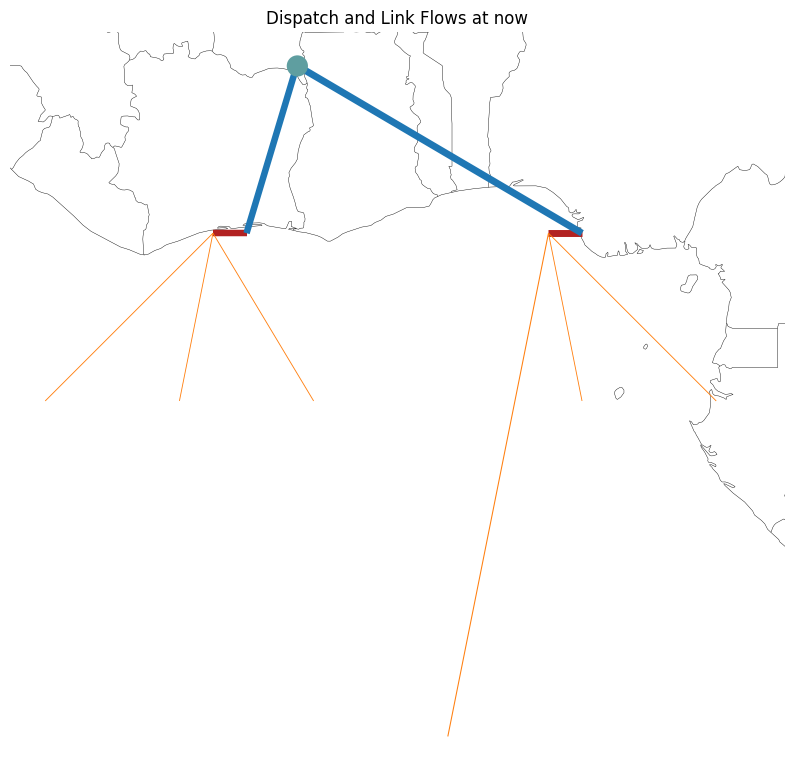

In [7]:
plt.figure(figsize=(10, 10))
carrier_colors = {
    'CH4': 'tab:blue',
    'Electricity': 'tab:orange',
}
special_colors = {
    "combustion": "firebrick",
    "electrolysis": "magenta"
}

def get_link_color(name, carrier):
    for prefix, color in special_colors.items():
        if name.startswith(prefix):
            return color
    return carrier_colors.get(carrier, "gray")

# Map each link to its color
link_colors = [
    get_link_color(name, carrier)
    for name, carrier in zip(n.links.index, n.links.carrier)
]

snapshot = n.snapshots[0]  # pick a time step
flows = n.links_t.p0.loc[snapshot]  # MW at each link

# scale widths (adjust multiplier for visibility)
line_widths = abs(flows) / flows.abs().max() * 5  

bus_sizes = n.generators_t.p.loc[snapshot].groupby(n.generators.bus).sum().reindex(n.buses.index, fill_value=0)
bus_sizes = bus_sizes / bus_sizes.max() /10

n.plot(
    bus_sizes=bus_sizes,
    link_widths=abs(flows)/flows.abs().max()*5,
    link_colors = link_colors,
    title=f"Dispatch and Link Flows at {snapshot}"
)


In [25]:
def build_network(distribution_nodes,
                  load_nodes,
                  fuel_generation_nodes,
                  elec_generation_nodes,
                  electric_line_loss_decay = 0.0005,
                  fuel_line_loss_decay = 0.0005,
                  plotbool=False):
    n = pypsa.Network()
    n.add("Carrier", "CH4")
    n.add("Carrier", "Electricity")

    for i, distrib_node in distribution_nodes.iterrows():
        print(distrib_node)
        add_distribution_node(i+1,
                              n,
                              electrolysis=distrib_node["electrolysis"],
                              p_nom_combustion=distrib_node["p_nom_combustion"],
                              p_nom_electrolysis=distrib_node["p_nom_electrolysis"],
                              electrolysis_efficiency=distrib_node["electrolysis_efficiency"],
                              combustion_efficiency=distrib_node["combustion_efficiency"],
                              loc = distrib_node["loc"]
        )

    for i, load_node in load_nodes.iterrows():
        add_load_node(i+1,
                      n,
                      distrib_node=load_node["distribution_node"],
                      load = load_node["load"],
                      p_nom_combustion=load_node["p_nom_combustion"],
                      combustion_efficiency= load_node["combustion_efficiency"],
                      loc = load_node["loc"]
                      )
        
    for i, elec_gen_node in elec_generation_nodes.iterrows():
        add_elec_generation_node(i+1,
                                 n,
                                 elec_gen_node["nodes_served"],
                                 pmax=elec_gen_node["pmax"],
                                 loc=elec_gen_node["loc"],
                                 marg_cost = elec_gen_node["marg_cost"])
    for i, fuel_gen_node in fuel_generation_nodes.iterrows():
        add_fuel_generation_node(i+1,
                                 n,
                                 fuel_gen_node["nodes_served"],
                                 pmax=fuel_gen_node["pmax"],
                                 loc=fuel_gen_node["loc"],
                                 marg_cost = fuel_gen_node["marg_cost"])
    if plotbool:
        n.plot()

    bus_coords = n.buses[["x", "y"]]
    def calc_length(row):
        x0, y0 = bus_coords.loc[row.bus0]
        x1, y1 = bus_coords.loc[row.bus1]
        return np.sqrt((x1 - x0)**2 + (y1 - y0)**2)

    n.links["length"] = n.links.apply(calc_length, axis=1, )


    alpha_map = {
        "Electricity": electric_line_loss_decay,  
        "CH4": fuel_line_loss_decay      # 0.05% per km
    }

    mask = n.links["conversion"] == False\


    for carrier, alpha in alpha_map.items():
        carrier_mask = (n.links.carrier == carrier) & mask
        n.links.loc[carrier_mask, "efficiency"] = np.exp(-alpha * n.links.loc[carrier_mask, "length"])


    n.links["efficiency"] = np.clip(n.links["efficiency"], 0, 1)

    n.optimize(solver_name="highs", solver_options={"solver": "ipm"})

    if(plotbool):
        plt.figure(figsize=(10, 10))
        carrier_colors = {
            'CH4': 'tab:blue',
            'Electricity': 'tab:orange',
        }
        special_colors = {
            "combustion": "firebrick",
            "electrolysis": "magenta"
        }

        def get_link_color(name, carrier):
            for prefix, color in special_colors.items():
                if name.startswith(prefix):
                    return color
            return carrier_colors.get(carrier, "gray")

        # Map each link to its color
        link_colors = [
            get_link_color(name, carrier)
            for name, carrier in zip(n.links.index, n.links.carrier)
        ]

        snapshot = n.snapshots[0]  # pick a time step
        flows = n.links_t.p0.loc[snapshot]  # MW at each link

        # scale widths (adjust multiplier for visibility)
        line_widths = abs(flows) / flows.abs().max() * 5  

        bus_sizes = n.generators_t.p.loc[snapshot].groupby(n.generators.bus).sum().reindex(n.buses.index, fill_value=0)
        bus_sizes = bus_sizes / bus_sizes.max() /10

        n.plot(
            bus_sizes=bus_sizes,
            link_widths=abs(flows)/flows.abs().max()*5,
            link_colors = link_colors,
            title=f"Dispatch and Link Flows at {snapshot}"
        )
    return n


In [26]:
distribs = pd.DataFrame(columns = ["electrolysis", "p_nom_combustion", "p_nom_electrolysis", "electrolysis_efficiency", "combustion_efficiency", "loc"])
distribs.loc[0] = [True, 10, 10, 0.4, 0.4, (-5,5)]
distribs.loc[1] = [True, 10, 10, 0.4, 0.4, (5,5)]

loads = pd.DataFrame(columns=["distribution_node", "load", "p_nom_combustion", "combustion_efficiency", "loc"])
loads.loc[0] = [1, 1, 1000, 0.2, (-10,0)]
loads.loc[1] = [1, 1, 1000, 0.2, (-6,0)]
loads.loc[2] = [1, 1, 1000, 0.2, (-2,0)]

loads.loc[3] = [2, 1, 1000, 0.2, (10,0)]
loads.loc[4] = [2, 1, 1000, 0.2, (6,0)]
loads.loc[5] = [2, 1, 1000, 0.2, (2,0)]

elec_gens = pd.DataFrame(columns=["nodes_served", "pmax", "loc", "marg_cost"])
elec_gens.loc[0] = [[1,2], 1000, (-3, 10), 10]

fuel_gens = pd.DataFrame(columns=["nodes_served", "pmax", "loc", "marg_cost"])
fuel_gens.loc[0] = [[1,2], 1000, (3, 10), 10]

In [23]:
def fuelmiles(network):
    """
    Compute the total distance * flow summed over all links
    for each carrier type in a solved PyPSA network.
    """
    flows = network.links_t.p0.mean() 
    links = network.links.copy()

    df = links.join(flows.rename("flow"))

    df["distance_flow"] = df["length"] * df["flow"].abs()

    result = df.groupby("carrier")["distance_flow"].sum()

    return result

In [40]:
electric_decay = np.logspace(-4, -1, 6)
fuel_decay = np.logspace(-4, -1, 5)

elec, fuel = np.meshgrid(electric_decay, fuel_decay)

output = np.zeros(elec.shape)

for i in range(len(electric_decay)):
    for j in range(len(fuel_decay)):
        n = build_network(distribs,
                  loads,
                  fuel_gens,
                  elec_gens,
                  electric_line_loss_decay = electric_decay[i],
                  fuel_line_loss_decay = fuel_decay[j])
        ah = fuelmiles(n)
        fuel_miles = ah["CH4"]
        elec_miles = ah["Electricity"]
        output[j][i] = fuel_miles/(fuel_miles+elec_miles)
        print(fuel_miles/(fuel_miles+elec_miles))

electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.06s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.01e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.01e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.06s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.01e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.06s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.01e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.06s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.01e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.03e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.07s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.03e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.06s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.03e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.06s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.03e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.07s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.03e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.13e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.07s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.13e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.08s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.13e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.08s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.13e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.06s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.13e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.06s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.53e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.07s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.53e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.07s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.53e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.06s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.53e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.07s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 6.53e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object
electrolysis                 True
p_nom_combustion               10
p_nom_electrolysis             10
electrolysis_efficiency       0.4
combustion_efficiency         0.4
loc                        (5, 5)
Name: 1, dtype: object


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - solver: ipm
INFO:linopy.io: Writing time: 0.06s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 74 duals
Objective: 8.39e+01
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


0.0
electrolysis                  True
p_nom_combustion                10
p_nom_electrolysis              10
electrolysis_efficiency        0.4
combustion_efficiency          0.4
loc                        (-5, 5)
Name: 0, dtype: object


KeyboardInterrupt: 

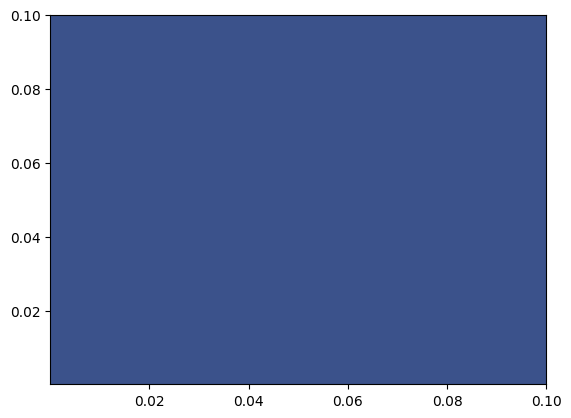

In [38]:
plt.contourf(elec, fuel , output)

In [39]:
output

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])